# Présentation des résultats

Après avoir trouvé et implémenté les différentes méthodes de classification et d'analyse du sentiment autour d'une phrase, nous avons pu effectuer des tests de précision et de recall sur un ensemble de donnée pré labélisé.

# Résultat de précision:

In [2]:
import time
import json

In [3]:
import matplotlib.pyplot as plt
import numpy as np

import sklearn.feature_extraction.text as skl_txt
import sklearn.linear_model as skl_lm
import sklearn.neighbors as skl_nei
import sklearn.ensemble as skl_en
import sklearn.naive_bayes as skl_nb
from sklearn import metrics as skl_metrics

In [28]:
data_dir = "../data/data_cleaned/labelised/"

path_hutto = data_dir + "hutto.txt"
path_airline = data_dir + "airline.txt"
path_kaggle = data_dir + "kaggle.txt"
path_michigan = data_dir + "michigan.txt"
path_rtneg = data_dir + "rt-polarity-neg.txt"
path_rtpos = data_dir + "rt-polarity-pos.txt"

data_files = {
    "hutto" : path_hutto, 
    "airline" : path_airline, 
    "kaggle" : path_kaggle, 
    "michigan" : path_michigan, 
    "rt-polarity-neg" : path_rtneg, 
    "rt-polarity-pos" : path_rtpos
             }

In [5]:
ngrams = (1,1)
binn = False
idf = True

In [48]:
def parse_file(file_path):
    f = open(file_path, "r")
    file_data = json.loads(f.readlines()[0])
    f.close()
    return np.array(file_data)

def vectorize_data(text_data, ngrams, binn, idf):
    if (binn == True):
        idf = False
    vectorizer = skl_txt.TfidfVectorizer(use_idf = idf, binary = binn, ngram_range = ngrams)
    return vectorizer.fit_transform(text_data) 

def parse_data(file_data):
    data, labels = file_data[:, 1], np.array(file_data[:, 0], dtype='int')
    data = vectorize_data(data, ngrams, binn, idf)
    return partition_data(data, labels)

def partition_data(data, labels, ratio = 0.7):
    N = int(ratio * data.shape[0])
    idx = np.random.permutation(data.shape[0])
    train_data = data[idx[:N]]
    train_labels = labels[idx[:N]]
    test_data = data[idx[N:]]
    test_labels = labels[idx[N:]]
    return train_data, train_labels, test_data, test_labels

def get_data(files):
    data = {}
    for key in files:
        file_data = parse_file(files[key])
        tr_data, tr_labels, te_data, te_labels = parse_data(file_data)
        partitioned_data = {
            'train_data': tr_data,
            'train_labels' : tr_labels,
            'test_data': te_data,
            'test_labels' : te_labels
        }
        data[key] = partitioned_data
    return data

In [7]:
def get_metrics(test_labels, predicted_labels):
    acc = skl_metrics.accuracy_score(test_labels, predicted_labels)
    recall = skl_metrics.recall_score(test_labels, predicted_labels)
    pre = skl_metrics.precision_score(test_labels, predicted_labels)
    return (pre, recall, acc)

In [8]:
def validate_performance(clf, data_train, train_labels, data_test, test_labels):
    clf.fit(data_train, train_labels)
    pr_lbls = clf.predict(data_test)
    return get_metrics(test_labels, pr_lbls)

In [51]:
def autolabels(rects, ax):
    for rect in rects:
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width()/2., 1.05*height,
                '%d' % int(height * 100) + "%",
                ha='center', va='bottom')

def plot_results(labels, results, plot_label):
    ind = np.arange(len(labels))  # the x locations for the groups
    width = 0.22    # the width of the bars
    fig, ax = plt.subplots()
    
    rects1 = ax.bar(ind , results[:,0], width, color='g')
    rects2 = ax.bar(ind - width, results[:,1], width, color='r')
    rects3 = ax.bar(ind + width, results[:,2], width, color='b')
    
    # add some text for labels, title and axes ticks
    ax.set_ylim(0,1.2)
    ax.set_ylabel('Pourcentage %')
    ax.set_title(plot_label)
    ax.set_xticks(ind)
    ax.set_xticks(ind)
    ax.set_xticklabels(labels, rotation = 'vertical')
    ax.legend((rects1[0], rects2[0], rects3[0]), ('precision', 'recall', 'accuracy'))
    
    autolabels(rects1, ax)
    autolabels(rects2, ax)
    autolabels(rects3, ax)
    plt.show()    

In [52]:
def benchmark(clfs, data, dataset_label):
    results = []
    train_data = data['train_data']
    train_labels = data['train_labels']
    test_data = data['test_data']
    test_labels = data['test_labels']
    for clf, name in clfs:
        results.append(validate_performance(clf, train_data, train_labels, test_data, test_labels))
    plot_results(clfs[:, 1], np.array(results), dataset_label)

In [53]:
clfs = np.array([[skl_nb.MultinomialNB(alpha=.01), "Multinomial NB"],
        [skl_nb.BernoulliNB(alpha=.01), "BernoulliNB"],
        [skl_lm.RidgeClassifier(tol=1e-2, solver="sag"), "Ridge Classifier"],
        [skl_lm.Perceptron(max_iter=50), "Perceptron"], 
        [skl_lm.PassiveAggressiveClassifier(max_iter=50), "Passive-Aggressive"],
        [skl_nei.KNeighborsClassifier(n_neighbors=10), "kNN"],
        [skl_en.RandomForestClassifier(n_estimators=100), "Random Forest"]])

In [54]:
all_data = get_data(data_files)

In [56]:
all_data.keys()

dict_keys(['hutto', 'airline', 'kaggle', 'michigan', 'rt-polarity-neg', 'rt-polarity-pos'])

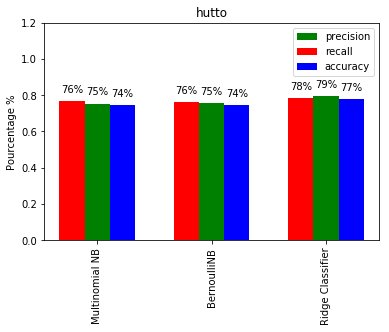

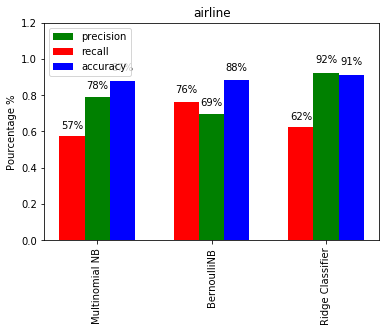

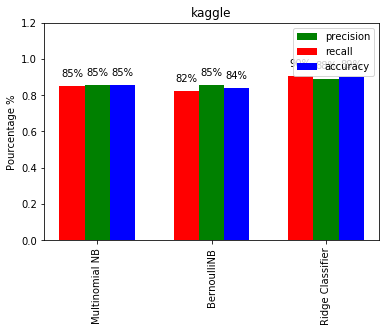

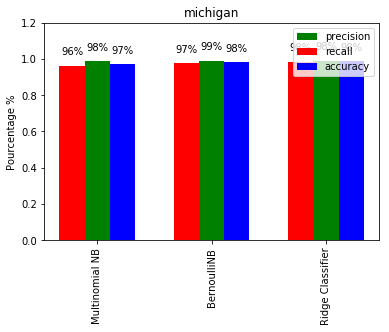

/usr/local/lib/python3.6/site-packages/sklearn/naive_bayes.py:461: RuntimeWarning: divide by zero encountered in log
  self.class_log_prior_ = (np.log(self.class_count_) -


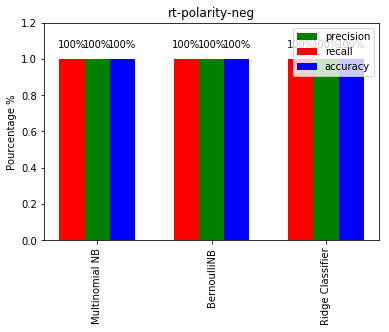

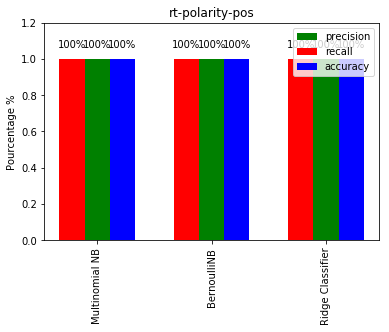

In [57]:
for dataset_label in all_data:
    benchmark(clfs[:3, :], all_data[dataset_label], dataset_label)